# STOCK MARKET PRICE PREDICTION - ARIMA

In [1]:
import sys
print (sys.version)
print(sys.executable)

3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
C:\Users\HP\anaconda3\python.exe


## 1.AMAZON

### Importing libraries and  also defined a matplotlib style of fivethirtyeight for plots

In [3]:
import pandas as pd
import numpy as np
import itertools

import warnings
warnings.filterwarnings("ignore")

import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

### Importing of Dataset

In [5]:
AMAZON = pd.read_csv('C:/Users/HP/Desktop/Stock market prediction/AMAZON.csv')
AMAZON.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2011-04-01,181.580002,183.250000,178.589996,180.130005,180.130005,5684100
1,2011-04-04,180.889999,183.610001,180.690002,182.940002,182.940002,4186400
2,2011-04-05,182.100006,186.360001,181.800003,185.289993,185.289993,5569200
3,2011-04-06,186.149994,188.270004,181.119995,182.759995,182.759995,5430700
4,2011-04-07,182.779999,185.169998,181.759995,184.910004,184.910004,4564000


### Removing columns,Sorted the data by date and checking of missing values

In [6]:
AMAZON.Date = pd.to_datetime(AMAZON.Date, format='%Y%m%d', errors='ignore')
cols = ['High', 'Low', 'Open', 'Volume', 'Adj Close']
AMAZON.drop(cols, axis=1, inplace=True)
AMAZON = AMAZON.sort_values('Date')
AMAZON.isnull().sum()

Date     0
Close    0
dtype: int64

In [7]:
AMAZON['Date'].min()

'2011-04-01'

In [8]:
AMAZON['Date'].max()

'2021-03-31'

### Creating Date column as index

In [9]:
#creation data column as index
AMAZON = AMAZON.set_index('Date')
AMAZON.index

Index(['2011-04-01', '2011-04-04', '2011-04-05', '2011-04-06', '2011-04-07',
       '2011-04-08', '2011-04-11', '2011-04-12', '2011-04-13', '2011-04-14',
       ...
       '2021-03-18', '2021-03-19', '2021-03-22', '2021-03-23', '2021-03-24',
       '2021-03-25', '2021-03-26', '2021-03-29', '2021-03-30', '2021-03-31'],
      dtype='object', name='Date', length=2516)

### Preprocessing of Data
#### Weekly data is tricky to work and it take more time.So instead of using weekly data, we used averages of monthly data of Close Price and made conversion with resample()

In [10]:
AMAZON.index = pd.to_datetime(AMAZON.index)
monthly_mean = AMAZON.Close.resample('M').mean()

In [12]:
#creating monthly mean from 2011
monthly_mean['2011']

Date
2011-04-30    184.576500
2011-05-31    198.166667
2011-06-30    191.667272
2011-07-31    215.195001
2011-08-31    199.458694
2011-09-30    223.242857
2011-10-31    226.838095
2011-11-30    205.480951
2011-12-31    183.933811
Freq: M, Name: Close, dtype: float64

#Creating monthly mean from 2010
monthly_mean['2010':]

### Creating Time series data as Data Visualization

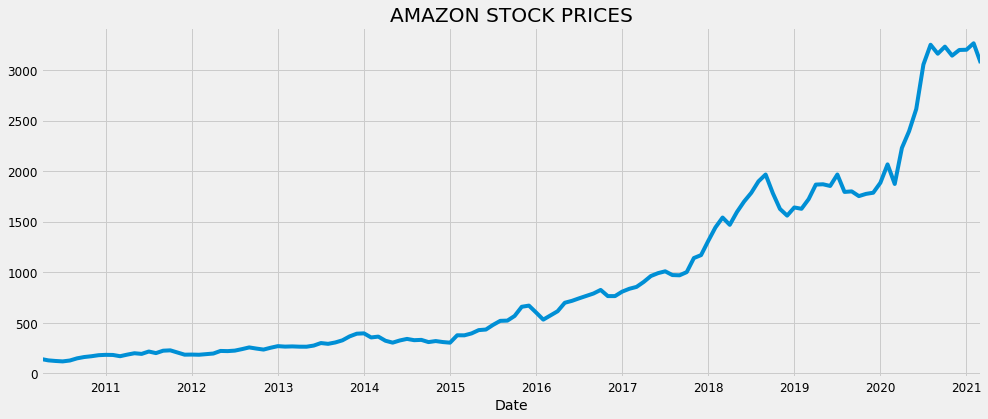

In [12]:
#Plotting the monthly mean
monthly_mean.plot(figsize=(15, 6), title = 'AMAZON STOCK PRICES')
plt.savefig('amznstock.pdf')
plt.show()

##### Some distinguishable patterns appears so the time-series has seasonality pattern

### Visualising the Distinct components of Data: Trend ,Seasonality and Noise

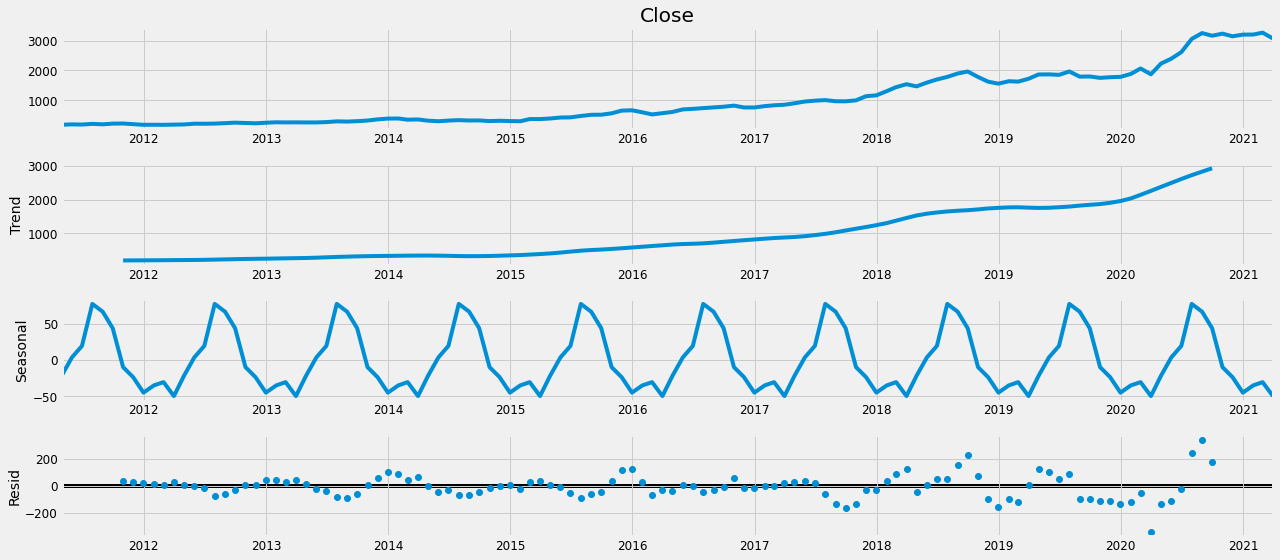

In [13]:
# Visualising the Distinct components: trend, seasonality, and noise.
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(monthly_mean, model='additive')
fig = decomposition.plot()
plt.savefig('amznstock_compnent.png')
plt.show()

#### The figure shows the close price is unstable

 ### ARIMA TIME SERIES MODEL

#### There are three distinct integers (p, d, q) that are used to parametrize ARIMA models. Because of that, ARIMA models are denoted with the notation ARIMA(p, d, q).
#### p is the auto-regressive part of the model. It allows us to incorporate the effect of past values into our model.
#### d is the integrated part of the model. It allows the number of past time points to subtract from the current value to apply to the time series.
#### q is the moving average part of the model. This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.
#### Here we are dealing with Seasonal Seasonal effect, Seasonal ARIMA defined as ARIMA(p,d,q)(P,D,Q)s. The term s is the periodicity of the time series (4 for quarterly periods, 12 for yearly periods).

In [14]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

import warnings
warnings.filterwarnings("ignore")

l_param = []
l_param_seasonal=[]
l_results_aic=[]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(monthly_mean,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            l_param.append(param)
            l_param_seasonal.append(param_seasonal)
            l_results_aic.append(results.aic)
        except:
            continue

minimum=l_results_aic[0]
for i in l_results_aic[1:]:
    if i < minimum: 
        minimum = i
i=l_results_aic.index(minimum)

mod = sm.tsa.statespace.SARIMAX(monthly_mean,
                                order=l_param[i],
                                seasonal_order=l_param_seasonal[i],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()
print("\n\n")
print(results.summary().tables[0])

print(results.summary().tables[1])

print(results.summary().tables[2])

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2248.1951448758787
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1969.5935890699252
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1800.9341317334558
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1633.629842282614
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1699.990968142019
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1605.3052549761776
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1628.598270859252
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1555.7635002805948
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2066.068637995101
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1806.8350296010651
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1656.6739981770952
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1497.4025039944743
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1592.7346311962583
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1503.4260965649319
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1517.3216628263456
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1446.0406690932468
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1524.1065287035171
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1395.8995502368

#### Using grid search, Identified the set of parameters that produces the best fitting model to our time series data.

### Plot Diagnostics

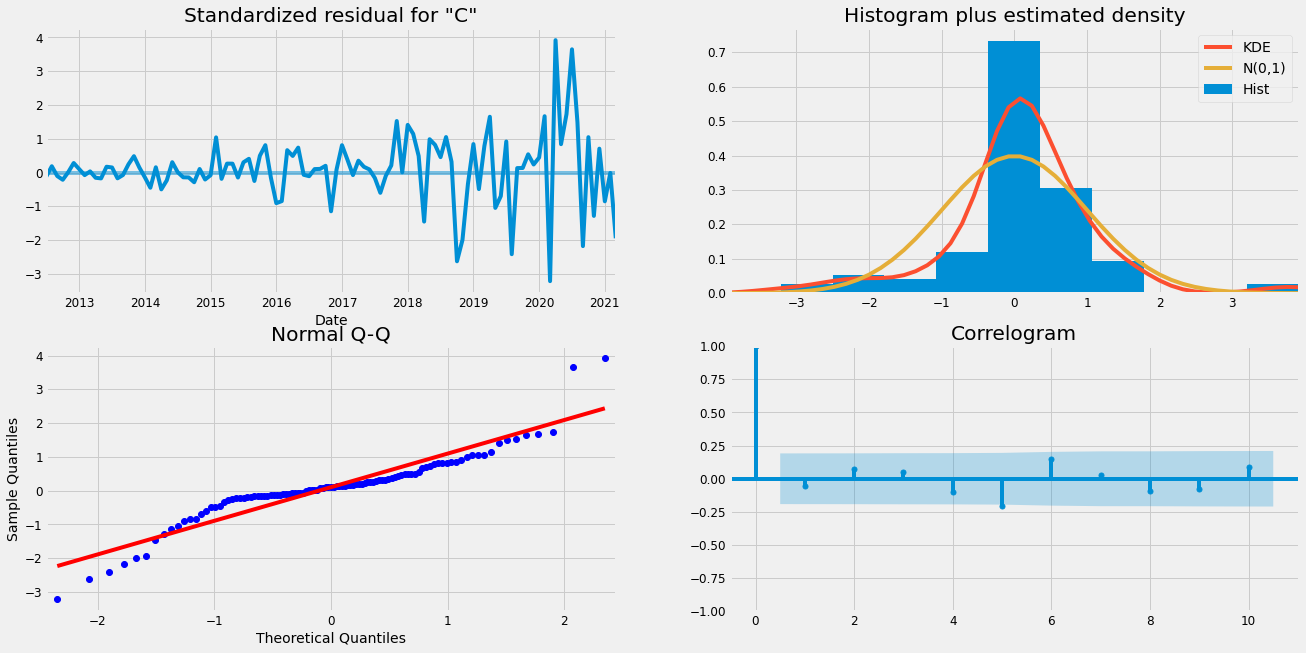

In [16]:
#Plotting the diagnostics results
results.plot_diagnostics(figsize=(20, 10))
plt.savefig('amznstock_diag.pdf')
plt.show()

#### Histogram plus estimated density shows the red line of KDE follows closely with the N(0,1) where in stands for standard notation with standard deviation 1 and mean 0. 
#### In the Q-Q Plot shows that blue dots follow the trend of standard normal distribution. 
#### The standard residual does not show any obvious seasonality and it is confirmed by the correlogram plot. 
#### In the Correlogram plot time series residual have low correlation.

### Prediction and Forecasting Graph

#### By comparing forecast values to real time series value. It helps us to understand the prediction accuracy. 
#### The attribute get_prediction() and coef_int() which helps to get the values and confidence interval for time series prediction. 
#### The dynamic = FALSE argument which means the forecast are generated at each point using the entire history.

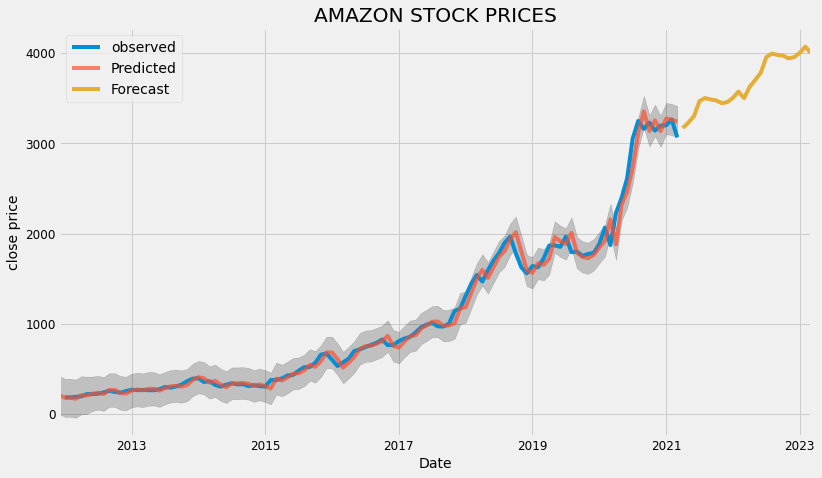

In [17]:
pred = results.get_prediction(start=pd.to_datetime('2011-12-31'), dynamic=False)
pred_uc = results.get_forecast(steps=24)
pred_ci = pred.conf_int()


ax = monthly_mean['2012':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Predicted', alpha=.7, figsize=(12, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

plt.title('AMAZON STOCK PRICES')
ax.set_xlabel('Date')
ax.set_ylabel('close price')
plt.legend()
plt.savefig('amznstock_pred.pdf')

plt.show()

### Forecast Validation

#### In statistics, the mean squared error (MSE) of an estimator measures the average of the squares of the errors. The MSE is a measure of the quality of an estimator. it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit.
#### Root Mean Square Error (RMSE) tells us that our model was able to forecast the average daily close price in the test set within portion of the real close price.

In [18]:
y_forecasted = pred.predicted_mean
y_truth = monthly_mean['2011-12-31':]

from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_truth, y_forecasted))
print('Mean Squared Error:', metrics.mean_squared_error(y_truth, y_forecasted))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_truth, y_forecasted)))

Mean Absolute Error: 54.62281905757571
Mean Squared Error: 7358.8388235904
Root Mean Squared Error: 85.78367457500524


## 2.APPLE

In [19]:
import pandas as pd
import numpy as np
import itertools

import warnings
warnings.filterwarnings("ignore")

import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [20]:
APPLE = pd.read_csv('C:/Users/HP/Downloads/AAPL.csv')
APPLE.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-04-01,8.478929,8.526071,8.312500,8.427500,7.259140,603145200
1,2010-04-05,8.392143,8.518214,8.384643,8.517500,7.336663,684507600
2,2010-04-06,8.507143,8.580000,8.464286,8.555000,7.368965,447017200
3,2010-04-07,8.555357,8.640000,8.523571,8.592857,7.401574,628502000
4,2010-04-08,8.587143,8.626429,8.501429,8.569643,7.381577,572989200


In [21]:
#removing columns,sorted by date and checking the missing values
APPLE.Date = pd.to_datetime(APPLE.Date, format='%Y%m%d', errors='ignore')
cols = ['High', 'Low', 'Open', 'Volume', 'Adj Close']
APPLE.drop(cols, axis=1, inplace=True)
APPLE = APPLE.sort_values('Date')
APPLE.isnull().sum()

Date     0
Close    0
dtype: int64

In [22]:
#creating Date coloumn as index
APPLE = APPLE.set_index('Date')
APPLE.index

Index(['2010-04-01', '2010-04-05', '2010-04-06', '2010-04-07', '2010-04-08',
       '2010-04-09', '2010-04-12', '2010-04-13', '2010-04-14', '2010-04-15',
       ...
       '2021-03-18', '2021-03-19', '2021-03-22', '2021-03-23', '2021-03-24',
       '2021-03-25', '2021-03-26', '2021-03-29', '2021-03-30', '2021-03-31'],
      dtype='object', name='Date', length=2769)

In [23]:
APPLE.index = pd.to_datetime(APPLE.index)
monthly_mean = APPLE.Close.resample('M').mean()

In [24]:
#Creating monthly mean from 2010
monthly_mean['2010':]

Date
2010-04-30      8.969592
2010-05-31      8.980768
2010-06-30      9.326624
2010-07-31      9.105357
2010-08-31      8.975828
                 ...    
2020-11-30    116.825999
2020-12-31    127.290455
2021-01-31    133.036842
2021-02-28    131.531579
2021-03-31    121.871304
Freq: M, Name: Close, Length: 132, dtype: float64

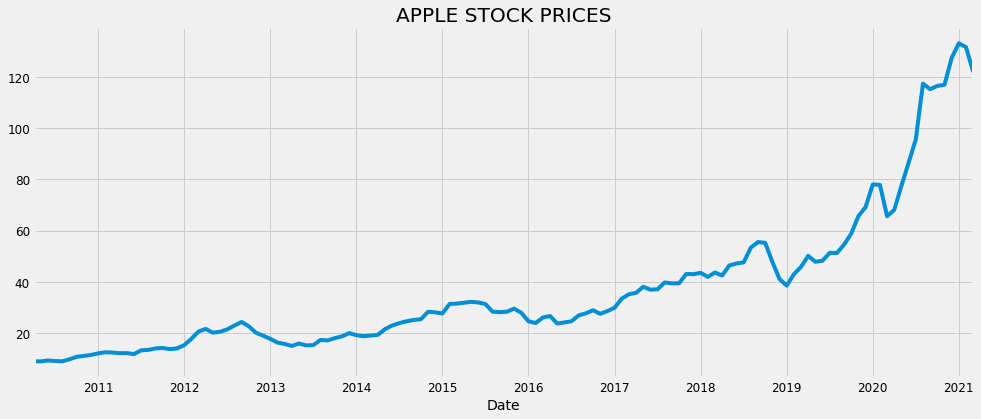

In [25]:
#Plotting the monthly mean
monthly_mean.plot(figsize=(15, 6), title = 'APPLE STOCK PRICES')
plt.savefig('applstock.pdf')
plt.show()

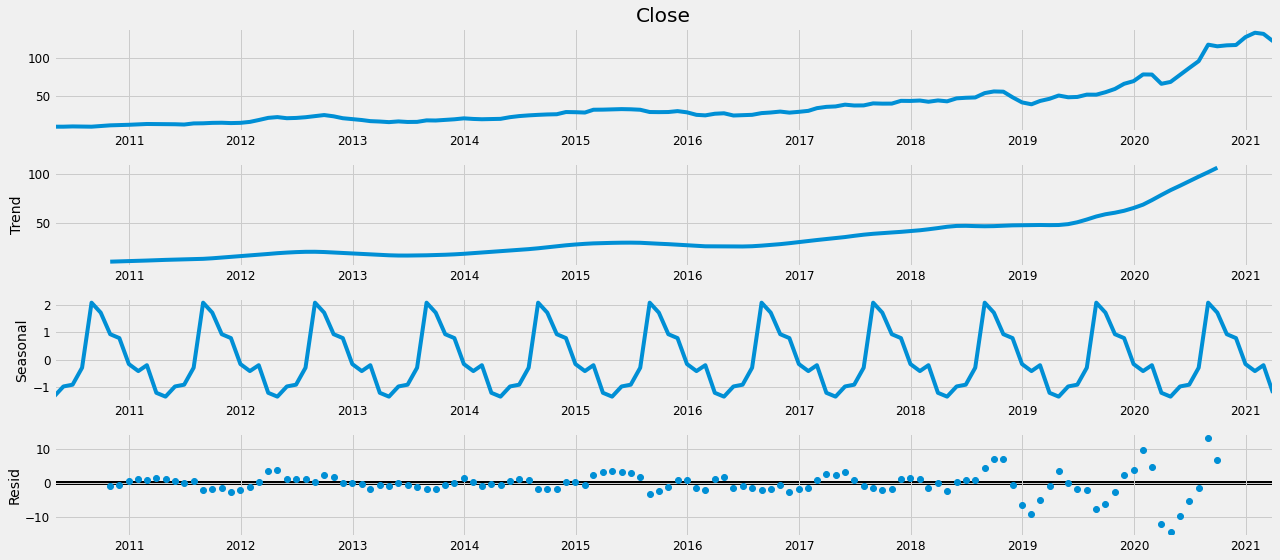

In [26]:
# Visualising the Distinct components: trend, seasonality, and noise.
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(monthly_mean, model='additive')
fig = decomposition.plot()
plt.savefig('applstock_compnent.pdf')
plt.show()

In [27]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

import warnings
warnings.filterwarnings("ignore")

l_param = []
l_param_seasonal=[]
l_results_aic=[]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(monthly_mean,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            l_param.append(param)
            l_param_seasonal.append(param_seasonal)
            l_results_aic.append(results.aic)
        except:
            continue

minimum=l_results_aic[0]
for i in l_results_aic[1:]:
    if i < minimum: 
        minimum = i
i=l_results_aic.index(minimum)

mod = sm.tsa.statespace.SARIMAX(monthly_mean,
                                order=l_param[i],
                                seasonal_order=l_param_seasonal[i],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()
print("\n\n")
print(results.summary().tables[0])

print(results.summary().tables[1])

print(results.summary().tables[2])

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1377.396051310719
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1180.4271305628035
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1035.6878743563568
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:930.286212140767
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:959.9521655868193
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:948.3871111423742
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:932.6126777456666
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:886.181774239994
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1199.3510972266672
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1024.0428215025863
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:891.7119830798869
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:807.642178405531
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:842.2324814371366
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:834.1106334954355
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:820.112865430797
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:778.9103200762721
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:705.0154765681225
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:653.1547863139008
ARIMA(0, 1

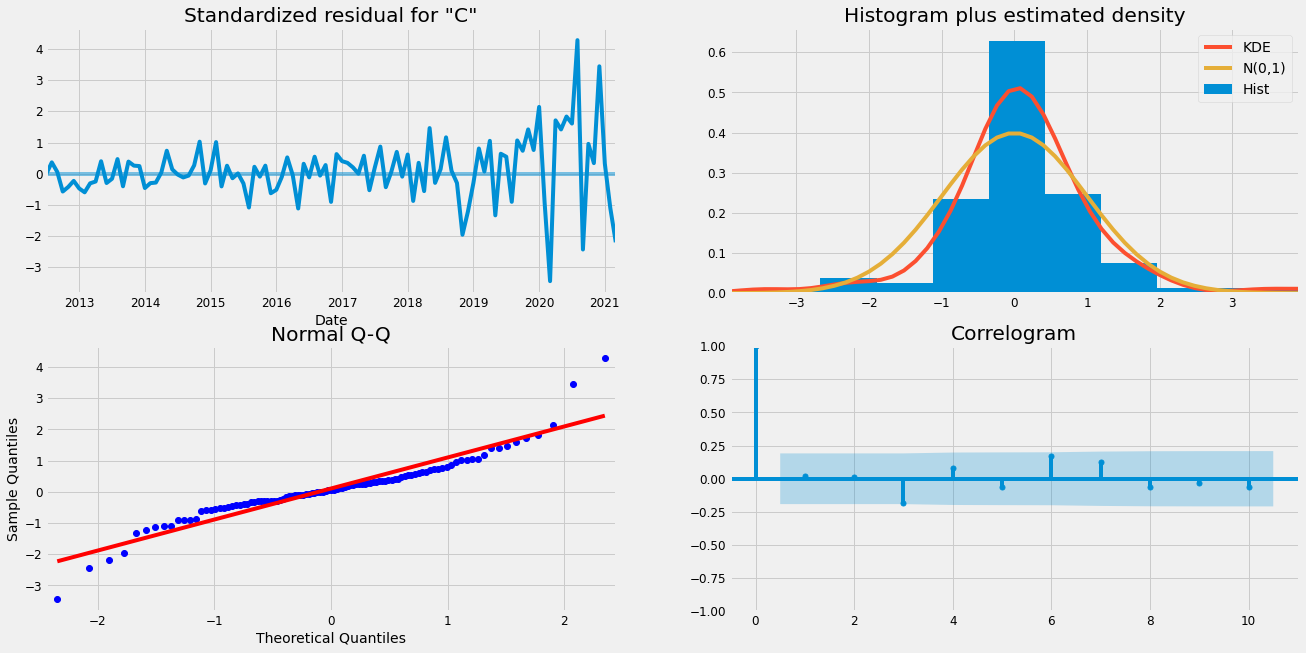

In [28]:
#Plotting the diagnostics results
results.plot_diagnostics(figsize=(20, 10))
plt.savefig('applstock_diag.pdf')
plt.show()

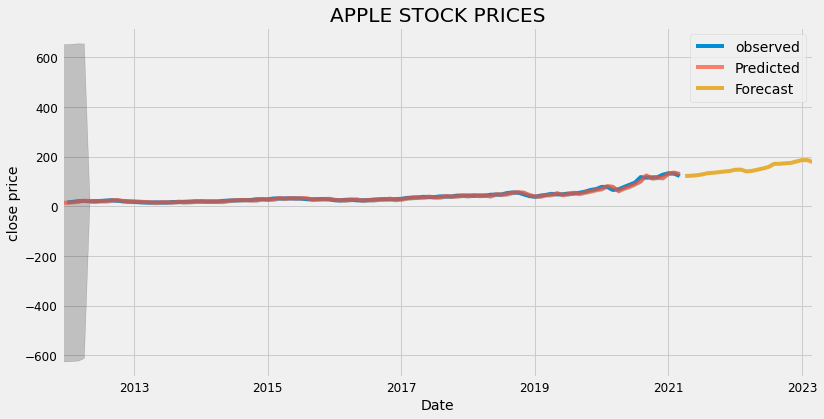

In [30]:
pred = results.get_prediction(start=pd.to_datetime('2011-12-31'), dynamic=False)
pred_uc = results.get_forecast(steps=24)
pred_ci = pred.conf_int()


ax = monthly_mean['2012':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Predicted', alpha=.7, figsize=(12, 6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

plt.title('APPLE STOCK PRICES')
ax.set_xlabel('Date')
ax.set_ylabel('close price')
plt.legend()
plt.savefig('applstock_pred.pdf')

plt.show()

In [59]:
y_forecasted = pred.predicted_mean
y_truth = monthly_mean['2011-12-31':]

from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_truth, y_forecasted))
print('Mean Squared Error:', metrics.mean_squared_error(y_truth, y_forecasted))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_truth, y_forecasted)))

Mean Absolute Error: 2.4626403305743603
Mean Squared Error: 13.477614122293293
Root Mean Squared Error: 3.6711870181581996


## 3. GOOGLE

In [60]:
import pandas as pd
import numpy as np
import itertools

import warnings
warnings.filterwarnings("ignore")

import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [61]:
GOOGLE = pd.read_csv('C:/Users/HP/Downloads/GOOG.csv')
GOOGLE.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-04-01,284.608215,285.654297,281.719055,283.337982,283.337982,4221163
1,2010-04-05,284.384064,286.366638,283.437592,284.438843,284.438843,3817255
2,2010-04-06,283.666748,284.379089,281.644318,283.049072,283.049072,4135644
3,2010-04-07,282.590790,283.313080,279.880951,280.717804,280.717804,5181348
4,2010-04-08,280.608215,283.861023,278.979309,282.685425,282.685425,3909599


In [62]:
#removing columns,sorted by date and checking the missing values
GOOGLE.Date = pd.to_datetime(GOOGLE.Date, format='%Y%m%d', errors='ignore')
cols = ['High', 'Low', 'Open', 'Volume', 'Adj Close']
GOOGLE.drop(cols, axis=1, inplace=True)
GOOGLE = GOOGLE.sort_values('Date')
GOOGLE.isnull().sum()

Date     0
Close    0
dtype: int64

In [63]:
#creating Date coloumn as index
GOOGLE = GOOGLE.set_index('Date')
GOOGLE.index

Index(['2010-04-01', '2010-04-05', '2010-04-06', '2010-04-07', '2010-04-08',
       '2010-04-09', '2010-04-12', '2010-04-13', '2010-04-14', '2010-04-15',
       ...
       '2021-03-18', '2021-03-19', '2021-03-22', '2021-03-23', '2021-03-24',
       '2021-03-25', '2021-03-26', '2021-03-29', '2021-03-30', '2021-03-31'],
      dtype='object', name='Date', length=2769)

In [64]:
GOOGLE.index = pd.to_datetime(GOOGLE.index)
monthly_mean = GOOGLE.Close.resample('M').mean()

In [65]:
#Creating monthly mean from 2010
monthly_mean['2010':]

Date
2010-04-30     277.491086
2010-05-31     247.737919
2010-06-30     241.331340
2010-07-31     235.600009
2010-08-31     238.761651
                 ...     
2020-11-30    1748.348499
2020-12-31    1772.278182
2021-01-31    1808.383693
2021-02-28    2068.356824
2021-03-31    2059.844785
Freq: M, Name: Close, Length: 132, dtype: float64

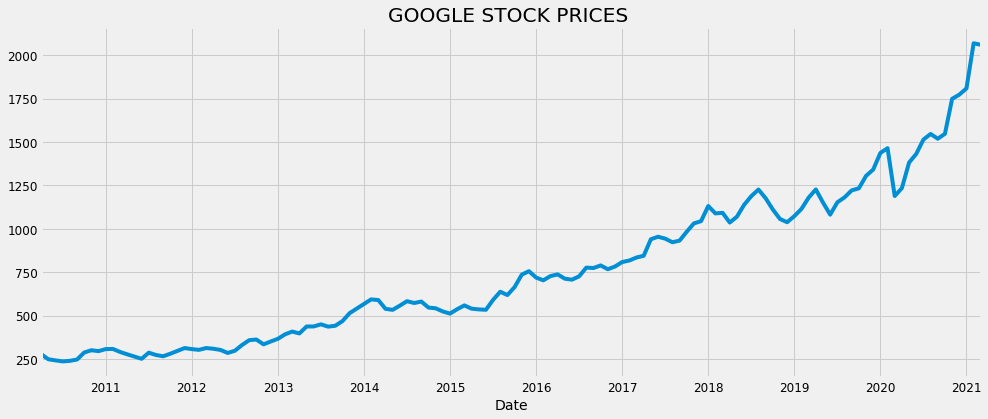

In [67]:
#Plotting the monthly mean
monthly_mean.plot(figsize=(15, 6), title = 'GOOGLE STOCK PRICES ')
plt.show()

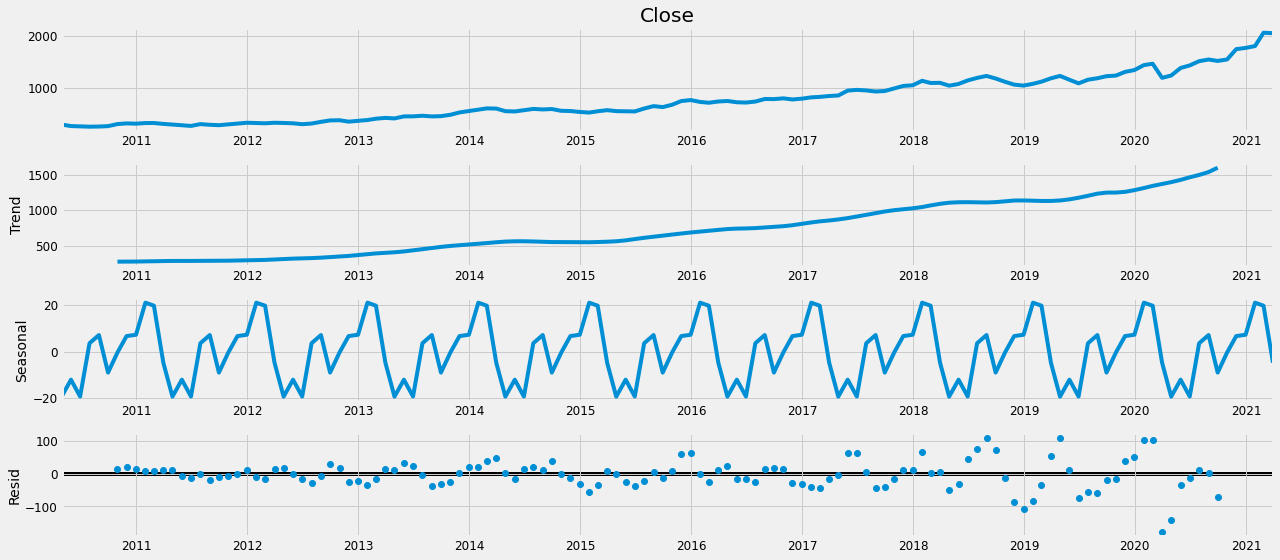

In [68]:
# Visualising the Distinct components: trend, seasonality, and noise.
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(monthly_mean, model='additive')
fig = decomposition.plot()
plt.show()

In [69]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

import warnings
warnings.filterwarnings("ignore")

l_param = []
l_param_seasonal=[]
l_results_aic=[]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(monthly_mean,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            l_param.append(param)
            l_param_seasonal.append(param_seasonal)
            l_results_aic.append(results.aic)
        except:
            continue

minimum=l_results_aic[0]
for i in l_results_aic[1:]:
    if i < minimum: 
        minimum = i
i=l_results_aic.index(minimum)

mod = sm.tsa.statespace.SARIMAX(monthly_mean,
                                order=l_param[i],
                                seasonal_order=l_param_seasonal[i],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()
print("\n\n")
print(results.summary().tables[0])

print(results.summary().tables[1])

print(results.summary().tables[2])

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2148.92236115365
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1853.6577510424847
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1596.2623576224344
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1449.998720239017
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1500.02071486973
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1429.734874863781
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1435.4383491970334
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1376.7849872759857
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1965.7261031484372
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1806.1413727256365
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1454.1288272543413
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1319.5009410258383
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1402.9132757583884
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1325.2217143982602
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1333.7300620321987
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1279.1522974531529
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1400.816734200486
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1284.1460333451987

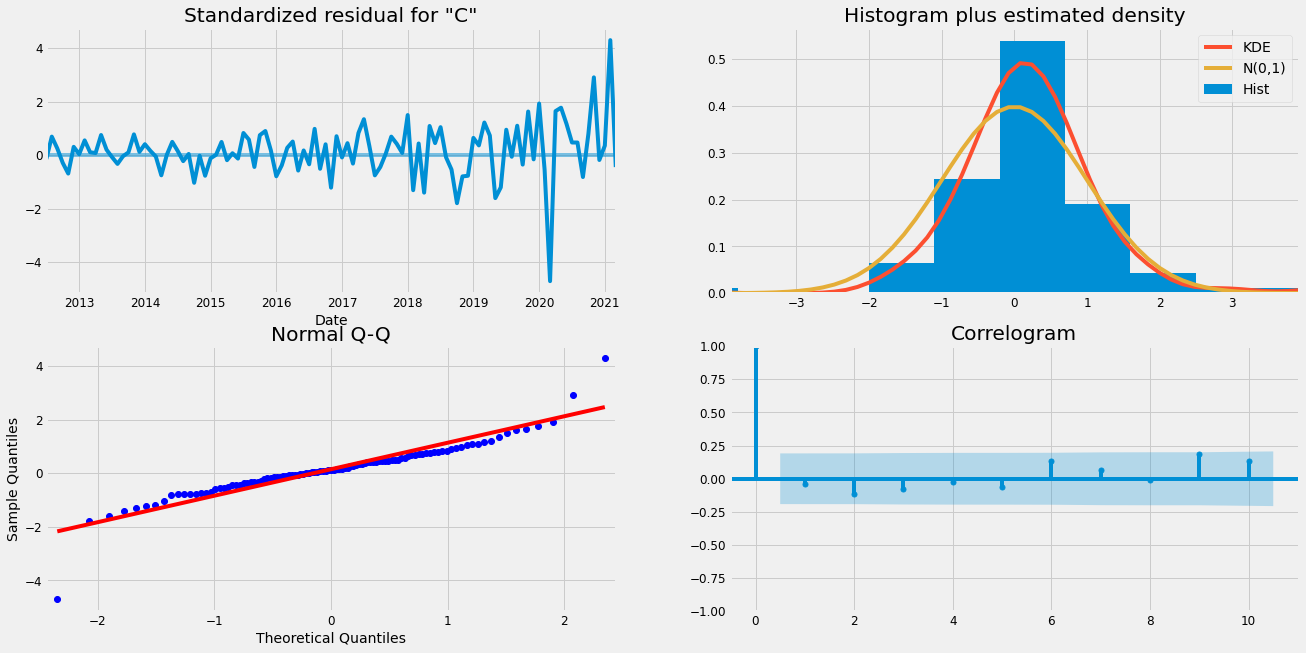

In [70]:
#Plotting the diagnostics results
results.plot_diagnostics(figsize=(20, 10))
plt.show()

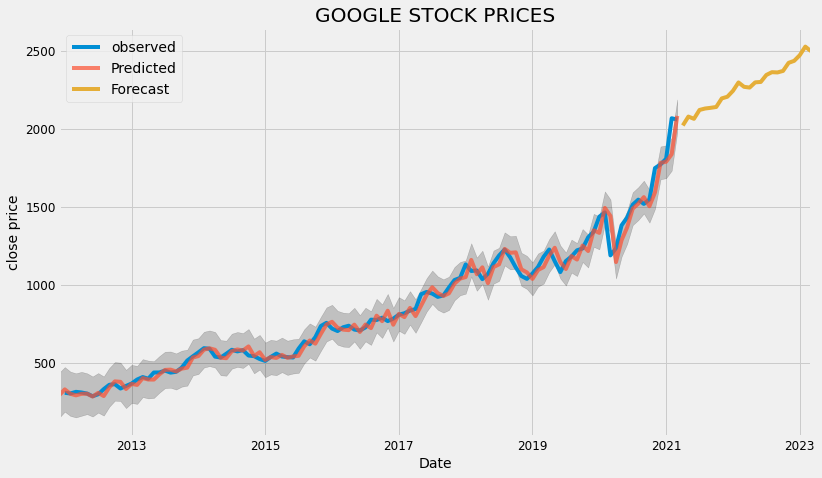

In [71]:
pred = results.get_prediction(start=pd.to_datetime('2011-12-31'), dynamic=False)
pred_uc = results.get_forecast(steps=24)
pred_ci = pred.conf_int()


ax = monthly_mean['2012':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Predicted', alpha=.7, figsize=(12, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

plt.title('GOOGLE STOCK PRICES')
ax.set_xlabel('Date')
ax.set_ylabel('close price')
plt.legend()

plt.show()

In [72]:
y_forecasted = pred.predicted_mean
y_truth = monthly_mean['2011-12-31':]

from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_truth, y_forecasted))
print('Mean Squared Error:', metrics.mean_squared_error(y_truth, y_forecasted))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_truth, y_forecasted)))

Mean Absolute Error: 35.488297471602756
Mean Squared Error: 2782.8208529234244
Root Mean Squared Error: 52.752448786036695
